In [1]:
import numpy as np
from keras.models import Sequential, Model
from keras.layers import Embedding, Reshape, Activation, Input, Dense
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import skipgrams
from keras.layers import dot



# Corpus

In [2]:
import re

def processing_text(texto):
    # Paso 1: Remover con un expresión regular carateres especiales (no palabras).
    processed_feature = re.sub(r'\W', ' ', str(texto))
    # Paso 2: Remover ocurrencias de caracteres individuales
    processed_feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)
    processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature)
    # Paso 3: Remover números (Ocurrencias muy esporádicas en nuestro dataset)
    processed_feature = re.sub(r'[0-9]+', ' ', processed_feature)
    # Paso 4: Simplificar espacios concecutivos a un único espacio entre palabras
    processed_feature = re.sub(' +', ' ', processed_feature)
    # Paso 5: Pasar todo el texto a minúsculas
    processed_feature = processed_feature.lower()

    return processed_feature

In [5]:
corpus = open("Alices_Adventures_in_Wonderland.txt").readlines()

corpus = [processing_text(sentence) for sentence in corpus]
corpus = [sentence for sentence in corpus if sentence!=' ' and sentence!='' and len(sentence.split())>3]
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
vocab_size = len(tokenizer.word_index) + 1
sequences = tokenizer.texts_to_sequences(corpus)


In [6]:
vocab_size

2973

In [7]:
corpus[0]

' the project gutenberg ebook of alice adventures in wonderland by lewis carroll '

In [8]:
sequences[0]

[1, 45, 41, 320, 4, 10, 348, 9, 515, 48, 1646, 1647]

# Skipgram with negative sampling (SGNS)

In [9]:
# Generador de skip-grams
skip_grams = [skipgrams(sequence, vocabulary_size=vocab_size, window_size=3) for sequence in sequences]

# Visualización skip-grams
pairs, labels = skip_grams[0][0], skip_grams[0][1]
print(pairs, labels)

[[348, 2267], [1, 1050], [10, 1788], [9, 901], [45, 4], [348, 10], [9, 48], [41, 1207], [1647, 515], [4, 2343], [1, 320], [348, 1188], [4, 320], [48, 9], [4, 10], [1646, 515], [515, 1187], [4, 41], [9, 2596], [320, 45], [320, 1600], [515, 9], [1646, 1647], [4, 348], [515, 5], [348, 323], [1, 45], [41, 1], [1, 2305], [9, 10], [10, 320], [9, 515], [48, 1295], [515, 2385], [1646, 48], [10, 2573], [41, 10], [9, 4], [48, 1647], [348, 198], [4, 9], [9, 456], [1647, 1776], [48, 348], [1646, 1632], [348, 9], [48, 73], [48, 1646], [10, 1199], [45, 1843], [10, 348], [41, 1038], [45, 320], [10, 723], [4, 1689], [515, 1647], [1647, 2685], [45, 1624], [348, 456], [41, 1550], [515, 2091], [320, 1347], [320, 1], [320, 10], [48, 1676], [1647, 1646], [1647, 48], [515, 806], [348, 48], [4, 45], [515, 48], [515, 348], [9, 583], [41, 320], [348, 320], [1646, 2797], [10, 9], [320, 462], [45, 2812], [48, 214], [9, 1646], [41, 1599], [1646, 877], [348, 4], [1646, 2529], [48, 2154], [9, 958], [48, 515], [4, 1

In [10]:
word2id = tokenizer.word_index
id2word = {v: k for k, v in word2id.items()}

for i in range(len(pairs)): #Visualizing the result
    print("({:s} , {:s} ) -> {:d}".format(
          id2word[pairs[i][0]],
          id2word[pairs[i][1]],
          labels[i]))

(adventures , vote ) -> 0
(the , fellow ) -> 0
(alice , signify ) -> 0
(in , creating ) -> 0
(project , of ) -> 1
(adventures , alice ) -> 1
(in , by ) -> 1
(gutenberg , longitude ) -> 0
(carroll , wonderland ) -> 1
(of , thunder ) -> 0
(the , ebook ) -> 1
(adventures , remarkable ) -> 0
(of , ebook ) -> 1
(by , in ) -> 1
(of , alice ) -> 1
(lewis , wonderland ) -> 1
(wonderland , picking ) -> 0
(of , gutenberg ) -> 1
(in , shifting ) -> 0
(ebook , project ) -> 1
(ebook , redistributing ) -> 0
(wonderland , in ) -> 1
(lewis , carroll ) -> 1
(of , adventures ) -> 1
(wonderland , it ) -> 0
(adventures , pool ) -> 0
(the , project ) -> 1
(gutenberg , the ) -> 1
(the , onions ) -> 0
(in , alice ) -> 1
(alice , ebook ) -> 1
(in , wonderland ) -> 1
(by , advisable ) -> 0
(wonderland , screaming ) -> 0
(lewis , by ) -> 1
(alice , rightly ) -> 0
(gutenberg , alice ) -> 1
(in , of ) -> 1
(by , carroll ) -> 1
(adventures , let ) -> 0
(of , in ) -> 1
(in , pepper ) -> 0
(carroll , dried ) -> 0
(b

# Arquitectura

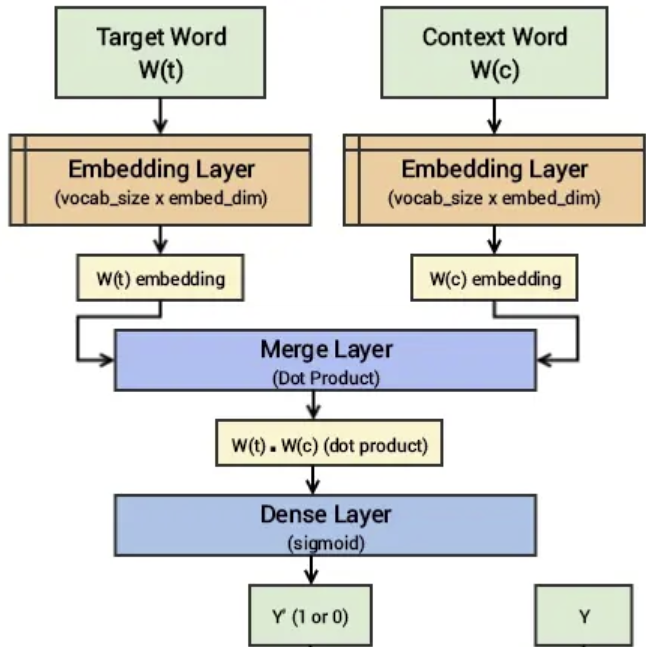

In [11]:
embed_size = 128

# https://keras.io/api/layers/initializers/

word_model = Sequential()
word_model.add(Embedding(vocab_size, embed_size,
               embeddings_initializer="glorot_uniform",
               input_length=1))
word_model.add(Reshape((embed_size, )))

context_model = Sequential()
context_model.add(Embedding(vocab_size, embed_size,
                  embeddings_initializer="glorot_uniform",
                  input_length=1))
context_model.add(Reshape((embed_size,)))

dot_product = dot([word_model.output, context_model.output], axes=1,
                  normalize=False)
dot_product = Dense(1, kernel_initializer="glorot_uniform",
              activation="sigmoid")(dot_product)
model = Model(inputs=[word_model.input, context_model.input],
              outputs=dot_product)
model.compile(loss="binary_crossentropy", optimizer="adam")

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 embedding_input (InputLayer)   [(None, 1)]          0           []                               
                                                                                                  
 embedding_1_input (InputLayer)  [(None, 1)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 128)       380544      ['embedding_input[0][0]']        
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 128)       380544      ['embedding_1_input[0][0]']      
                                                                                              

In [15]:
print(len(skip_grams))
for epoch in range(1, 10):
    loss = 0
    for i, elem in enumerate(skip_grams):
        pair_first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
        pair_second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
        labels = np.array(elem[1], dtype='int32')
        X = [pair_first_elem, pair_second_elem]
        Y = labels
        #print(i)
        loss += model.train_on_batch(X,Y)
    print('Epoch:', epoch, 'Loss:', loss)

2586
Epoch: 1 Loss: 1033.585082218051
Epoch: 2 Loss: 907.4798924773932
Epoch: 3 Loss: 758.227707117796
Epoch: 4 Loss: 598.0486987223849
Epoch: 5 Loss: 477.5025397988502
Epoch: 6 Loss: 405.79944007028826
Epoch: 7 Loss: 371.5977136656584
Epoch: 8 Loss: 351.14287366726785
Epoch: 9 Loss: 340.00542726508866


# Word Embeddings

In [16]:
import pandas as pd

word_embed_layer = word_model.layers[0]
weights = word_embed_layer.get_weights()[0][1:]

print(weights.shape)
pd.DataFrame(weights, index=id2word.values()).head()


(2972, 128)


,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
the,0.077923,-0.009558,0.013800,0.115823,0.033177,0.046959,0.025251,-0.016542,-0.031794,-0.152918,...,-0.012052,-0.064920,-0.028882,-0.010306,-0.004859,-0.014367,0.086814,0.009102,0.006730,-0.101949
and,-0.000756,0.039712,-0.063416,-0.109802,-0.049486,0.067351,0.048643,0.009677,0.065773,-0.034723,...,0.079983,-0.011276,0.069074,-0.077637,-0.042054,-0.085962,-0.010088,0.007959,0.045701,0.033070
to,-0.073686,-0.020699,0.030065,-0.038143,0.259685,-0.138526,0.239023,-0.042864,0.031789,-0.283245,...,-0.037646,-0.001406,-0.119175,0.093124,-0.122516,0.014560,-0.053717,0.472792,0.115228,0.005478
of,0.031422,-0.012928,-0.100958,0.025923,0.037916,-0.095456,-0.128450,0.191600,0.124767,0.279482,...,0.057697,-0.293036,-0.063370,-0.042545,0.194678,-0.162631,0.021506,0.301011,0.011305,-0.076431
it,-0.059733,-0.004135,0.187079,-0.075099,-0.037669,0.014228,-0.058306,-0.030038,0.025038,0.144888,...,0.137969,0.026808,0.018804,0.053199,-0.131832,-0.073443,-0.037972,-0.096707,-0.021155,-0.065407


(2972, 2972)
{'alice': ['usurpation', 'michael', 'fitness', 'chuckled', 'goals'], 'cat': ['drink', 'fly', 'opportunities', 'rattle', 'attempt'], 'rabbit': ['paris', 'dressed', 'splendidly', 'est', 'teacup'], 'queen': ['fair', 'jug', 'shrieked', 'viii', 'reeds'], 'rose': ['poker', 'dig', 'professor', 'feathers', 'hart']}


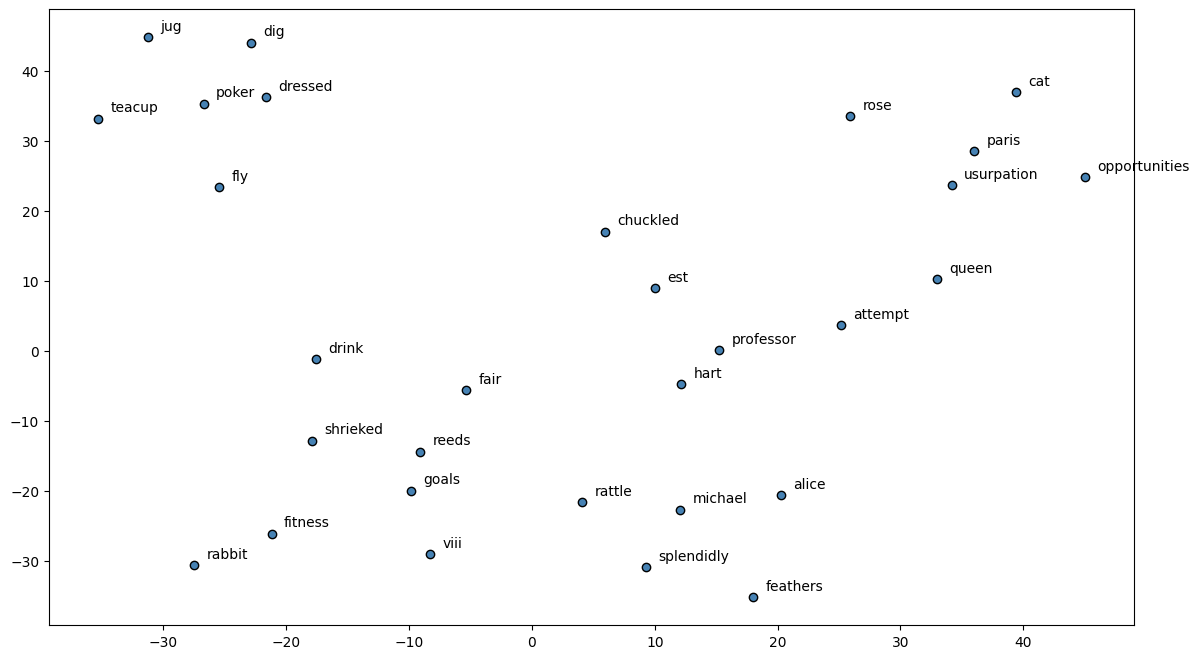

In [21]:
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt

distance_matrix = euclidean_distances(weights)
print(distance_matrix.shape)

similar_words = {search_term: [id2word[idx] for idx in distance_matrix[word2id[search_term]-1].argsort()[1:6]+1]
                   for search_term in ['alice', 'cat', 'rabbit', 'queen', 'rose']}

print(similar_words)

words = sum([[k] + v for k, v in similar_words.items()], [])
words_ids = [word2id[w] for w in words]
word_vectors = np.array([weights[idx] for idx in words_ids])

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=3)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(word_vectors)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='steelblue', edgecolors='k')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')